In [2]:
"""
Read dataset file using pandas.
"""

from pandas import read_csv

dataset_path = "./dataset/spotify.csv"

raw_df = read_csv(dataset_path)


In [3]:
"""
Reduce data size
"""

df = raw_df.sample(n=10_000)


In [4]:
"""
Standardization
"""

from sklearn.preprocessing import StandardScaler

features = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for i, feature in enumerate(features):
    df[feature] = X_scaled.T[i]

df.head()


,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
669234,0Q8VAWcDloiXjyO73weear,El Son de la Puntillita - Son,Havana Nights,2y3BlOYmzkleQSKPmUJucV,"['Manuel Licea ""Puntillita""']",['6GqHKBzTqdVlAV0vvPmpUw'],4,1,False,1.485601,...,-0.316498,0.729879,-0.769291,-0.673730,2.006879,0.621008,208733,4.0,1998,1998
653721,5ASM6Qjiav2xPe7gRkQMsQ,Sleigh Ride,A Christmas Gift For You From Phil Spector,2kzkwgOFAtRsDsas5Hi0Qu,['The Ronettes'],['7CyeXFnOrfC1N6z4naIpgo'],5,1,False,0.202544,...,-0.474934,-0.124749,-0.769333,0.656816,1.578331,-0.832161,181267,4.0,1963,1963
1112035,4pk56nIjkPvgSNf7khrrsL,Use Me,In Your Eyes,4QZ7wq0y0io4KdNDqF81y8,['George Benson'],['4N8BwYTEC6XqykGvXXlmfv'],8,1,False,1.264747,...,-0.481712,0.233727,-0.769315,-0.847672,0.750790,-0.476260,263333,4.0,1983,1983-05-18
913918,1Ppv9AqZSR6tB11ZbzttR8,Gingerbread Man,The Fact Remains,74X8vV8NLfbizjxlHDofcz,['Armored Theory'],['6magjXlStH3IbTRUxhymaj'],3,1,True,0.502275,...,-0.416474,-1.165604,-0.769250,-0.540449,-1.081623,0.401341,214052,4.0,2018,2018-05-08
1061895,0TrGNhdvkzqCsjzi1etUVw,Mama Told Me,Doo-lang Doo-lang,6nlqyAI25Dt3kIw6Uzqlax,['The Emergency'],['6ag8qlRWks05uAa39HajN6'],7,1,False,-0.559928,...,0.065612,-1.128743,-0.695044,-0.517859,-0.187583,-0.141234,279440,4.0,2006,2006-10-26


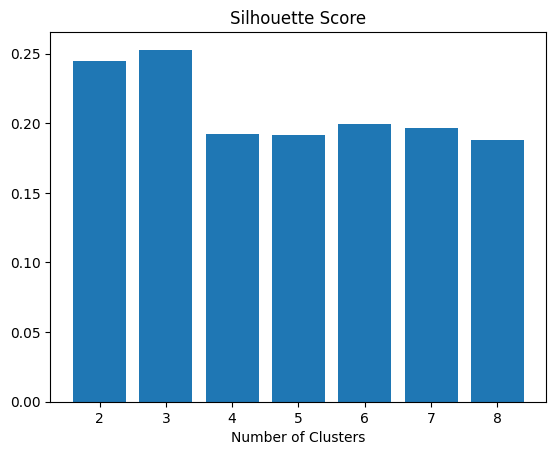

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

kmeans = KMeans()
n_clusters_range = range(2, len(features) + 1)

best_score = -1
best_n_clusters = 1
silhouette_scores = []

for n_clusters in n_clusters_range:
    kmeans.set_params(
        **{
            "n_clusters": n_clusters,
            "init": "k-means++",
            "n_init": "auto",
            "random_state": 42,
        }
    )
    kmeans.fit(X_scaled)

    ss = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores += [ss]

    if ss > best_score:
        best_score = ss
        best_n_clusters = n_clusters

plt.bar(range(len(silhouette_scores)), list(silhouette_scores))
plt.xticks(range(len(silhouette_scores)), list(n_clusters_range))
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.show()


In [6]:
kmeans = KMeans(
    n_clusters=best_n_clusters, init="k-means++", n_init="auto", random_state=42
)
kmeans.fit(X_scaled)

df["cluster"] = kmeans.predict(X_scaled)


In [7]:
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px

perplexity = 30
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

positions = tsne.fit_transform(X_scaled)

df.loc[:, ["position_x", "position_y"]] = positions

tsne_df = pd.DataFrame(df, columns=["position_x", "position_y", "cluster", "name"])

fig = px.scatter(
    tsne_df,
    x="position_x",
    y="position_y",
    color="cluster",
    hover_data=["position_x", "position_y", "name"],
)
fig.show()


In [8]:
"""
Connect to Spotify via spotipy library.
"""

from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials
from dotenv import dotenv_values

config = dotenv_values(".env")
CLIENT_ID = config["CLIENT_ID"]
CLIENT_SECRET = config["CLIENT_SECRET"]

auth_manager = SpotifyClientCredentials(
    client_id=CLIENT_ID, client_secret=CLIENT_SECRET
)
sp = Spotify(auth_manager=auth_manager)


In [9]:
def get_music_info(music):
    [music_id] = music["id"].values
    [music_danceability] = music["danceability"].values
    [music_energy] = music["energy"].values
    [music_speechiness] = music["speechiness"].values
    [music_acousticness] = music["acousticness"].values
    [music_instrumentalness] = music["instrumentalness"].values
    [music_liveness] = music["liveness"].values
    [music_valence] = music["valence"].values
    [music_tempo] = music["tempo"].values

    track = sp.track(track_id=music_id)

    name = track["name"]
    artists = track["artists"]
    artist_names = map(lambda x: x["name"], artists)
    preview_url = track["preview_url"]

    music_info = {
        "id": music_id,
        "name": name,
        "artist_names": artist_names,
        "preview_url": preview_url,
        "danceability": music_danceability,
        "energy": music_energy,
        "speechiness": music_speechiness,
        "acousticness": music_acousticness,
        "instrumentalness": music_instrumentalness,
        "liveness": music_liveness,
        "valence": music_valence,
        "tempo": music_tempo,
    }

    return music_info


In [10]:
from textwrap import dedent
from vlc import MediaPlayer


def print_music_info(name, artist_names):
    artist_name = " & ".join(artist_names)

    print(
        dedent(
            f"""
				---
				Now Playing
						
				Name: {name}
				Artist: {artist_name}
				---
			"""
        )
    )


def get_user_input():
    user_input = str(
        input(
            dedent(
                f"""
					Do you enjoy this music ?

					If yes, press (y).
					If no, press (n).

					Press (s) to stop/pause the music.
					Press (p) to play/resume the music.
					Press (e) to exit.
				"""
            )
        )
    )
    user_input_lowercase = user_input.lower()

    if user_input_lowercase in ["s", "p", "y", "n", "e"]:
        return user_input_lowercase
    else:
        return get_user_input()


In [11]:
from numpy.random import randint

musics_num = df.shape
liked_music_infos = []

is_exit = False

while is_exit == False:
    music_info = None

    while music_info is None:
        play_music_index = randint(low=0, high=musics_num, size=1)

        music = df.iloc[play_music_index, :]
        music_info_ = get_music_info(music)

        preview_url = music_info_["preview_url"]
        if preview_url is not None:
            music_info = music_info_

    name = music_info["name"]
    artist_names = music_info["artist_names"]
    preview_url = music_info["preview_url"]

    print_music_info(name, artist_names)

    media_player = MediaPlayer(preview_url)
    media_player.play()

    is_finish = False

    while is_finish != True:
        user_input = get_user_input()

        if user_input == "e":
            media_player.stop()

            is_finish = True
            is_exit = True
        elif user_input == "s":
            media_player.set_pause(True)
        elif user_input == "p":
            is_media_playing = media_player.is_playing()

            if is_media_playing:
                media_player.set_pause(False)
            else:
                media_player.play()
        elif user_input == "y":
            media_player.stop()
            is_finish = True

            liked_music_infos.append(music_info)
        elif user_input == "n":
            media_player.stop()
            is_finish = True



---
Now Playing

Name: Pictures at an Exhibition (Orch. M. Ravel): IX. The Hut on Fowl's Legs (Baba-Yaga)
Artist: Modest Mussorgsky & Maurice Ravel & Minnesota Orchestra & Eiji Oue
---


---
Now Playing

Name: Goin' Home
Artist: Scott Nolan
---


---
Now Playing

Name: Lee|Ah|Loo
Artist: Jeff Alexander Choir & C. Callinicos
---


---
Now Playing

Name: Damnations Valley - Bonus Track
Artist: White Willow
---


---
Now Playing

Name: Even Now A Glimpse
Artist: Ray Lyon
---


---
Now Playing

Name: Book of Horizons: IV. A World Full of Hope
Artist: Michael Byron & Joseph Kubera
---


---
Now Playing

Name: Piano Concerto No. 5 in E-Flat Major, Op. 73 "Emperor": III. Rondo. Allegro
Artist: Ludwig van Beethoven & Murray Perahia & Bernard Haitink & Royal Concertgebouw Orchestra
---



In [12]:
from math import sqrt
import pandas as pd

user_music_infos = liked_music_infos
user_music_length = len(user_music_infos)
user_music_ids = list(map(lambda x: x["id"], user_music_infos))

user_music_df = df[df["id"].isin(user_music_ids)].copy().reset_index(drop=True)
recommended_df = df[~df["id"].isin(user_music_ids)].copy().reset_index(drop=True)

recommended_music_ids = []

num_recommended_music = int(input("Number of recommended music"))

if num_recommended_music > 0:
    for num_index in range(0, num_recommended_music):
        user_music_index = 0 if num_index == 0 else num_index % user_music_length

        user_music = user_music_df.iloc[user_music_index, :]
        cluster = user_music["cluster"]
        position_x = user_music["position_x"]
        position_y = user_music["position_y"]

        recommended_music_id = None
        recommended_distance = None

        recommended_in_clusters = recommended_df[recommended_df["cluster"] == cluster]
        for _, recommended in recommended_in_clusters.iterrows():
            recommended_id = recommended["id"]
            recommended_position_x = recommended["position_x"]
            recommended_position_y = recommended["position_y"]

            distance = sqrt(
                ((position_x - recommended_position_x) ** 2)
                + ((position_y - recommended_position_y) ** 2)
            )

            if (
                (recommended_music_id is None)
                or (recommended_distance is None)
                or (distance < recommended_distance)
            ):
                recommended_music_id = recommended_id
                recommended_distance = distance

        recommended_df = recommended_df[recommended_df["id"] != recommended_music_id]

        recommended_music_ids.append(recommended_music_id)

recommended_musics = pd.DataFrame()
for recommended_music_id in recommended_music_ids:
    recommended_musics = pd.concat(
        [recommended_musics, df[df["id"] == recommended_music_id]]
    )

recommended_musics


,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,liveness,valence,tempo,duration_ms,time_signature,year,release_date,cluster,position_x,position_y
515432,6WK9yUb23PcxqqLdbNh5jB,"Rapsodia Cubana, Op. 66","Albéniz: Piano Music, Vol. 5",4WLqMbEv6Yqt8KnakQIMuI,"['Isaac Albéniz', 'Juan José Mudarra Gámiz']","['4sbcjbyksdT4dJ5Lh0SvZp', '69m4cdqVaqbatE0WA4...",12,1,False,-0.791299,...,-0.359730,-0.272553,-0.296113,299613,4.0,2014,2014-08-05,0,56.948574,-14.452475
358784,0cvO3P3dzLDTTuFm1rD3tc,"Concerto for Flute, Oboe d'amore and Viola d'a...",Telemann: Triple Concertos,7DD8oSDhfDefzWqaRrYk4F,"['Georg Philipp Telemann', 'Rachel Brown', 'An...","['2fg5h5pzleqI4RjFopWroj', '6Di0SJlBpTmXotR33q...",13,1,False,-1.858760,...,-0.066061,-1.192454,-1.378969,181080,4.0,2005,2005-06-01,0,56.359638,46.951771
477230,00d3X2tHaZYT8JyOSz5Xi5,Please Forgive Me,A Splendid Diagnosis,6Dw7IUBWBQDErFurt7Iz1D,['The Atlas Mountains'],['1TY3aeAC5bWbESN8ldeGnk'],10,1,False,0.444432,...,-0.648881,-0.542243,0.426610,220083,4.0,2011,2011-09-02,2,6.345351,24.641935
827615,4ZwuFIyEMeYVZDNHWGWsZb,Kayon,Tree of Life,77ycDqihEQPYD0JN5UfKsr,"['Mark Seelig', 'Loren Nerell']","['6dD0fVmFddCvKfO8jcHMPp', '20OutGhsYiZ1myKXgt...",4,1,False,-0.870175,...,-0.483974,-1.452908,-1.372862,850880,4.0,2014,2014-05-13,0,77.416138,-3.865167
686143,2bGZEkYYCDx88sWoSbNaga,Father and Son,The Fantastic Four (Original Motion Picture So...,4VkVAV4pNPOcHrQAnDZ5g3,"['Marco Beltrami', 'Philip Glass']","['7yAPsqNhqqsTGsuOSZJg0i', '69lxxQvsfAIoQbB20b...",20,1,False,-1.769367,...,2.249406,-1.444042,1.759411,109680,4.0,2015,2015-07-31,0,13.416503,-26.299847
44069,1XysSt1WavxpWYisXWFyDl,"The Nutcracker, Op. 71, TH 14, Act I Tableau 1...","Tchaikovsky: The Nutcracker, Op. 71, TH 14 (Ar...",0lxVdAWzAL5M2tGXjAw5v8,"['Pyotr Ilyich Tchaikovsky', 'Stewart Goodyear']","['3MKCzCnpzw3TjUYs2v7vDA', '6Uw4yKZKLOhjuix5CU...",2,1,False,-0.691389,...,-0.495269,-0.206055,-0.466114,216253,4.0,2015,2015-10-09,0,56.485195,-14.541300
331694,0QLTBzuIB0rk3Q6iigQldr,"The Dream of Gerontius, Op. 38: Part I: Jesu, ...","Elgar: The Dream of Gerontius, Op. 38",1wfvrYCNCjUqe9rRGhc8gj,"['Edward Elgar', 'Matthew Best', 'Neville Cree...","['430byzy0c5bPn5opiu0SRd', '0xTHMoXM5wpOUwNU2K...",2,1,False,-2.021771,...,-0.111241,-1.373109,-1.329756,331173,3.0,1997,1997-05-20,0,56.700523,46.919231
929557,6C0px7pWGH1I5npRI4JOhB,King and Country,Brother to Brother,4vV5jnDlAze6V2lSjQcMr8,['The Nimmo Brothers'],['0zlXwIHrPuat0HcLxJNqiZ'],11,1,False,0.349780,...,-0.636456,-0.394468,0.398013,352520,4.0,2012,2012-03-19,2,6.076601,24.688633
381066,73QED73xzYA4SVHKO8VT4P,"Piano Concerto No. 2 in G Minor, Op. 16: I. An...",Prokofiev: Piano Concertos Nos. 1-5,3GzZDmg592TZwPsFG4zToC,"['Sergei Prokofiev', 'Jean-Efflam Bavouzet', '...","['4kHtgiRnpmFIV5Tm4BIs8l', '4BcOHdtzeyl8hX3zUI...",5,1,False,-0.938535,...,-0.630244,-1.439608,-1.550683,669160,4.0,2014,2014,0,77.708656,-4.357009
369612,6VAc50d52pi6gxcQxbnbPD,The Golden Striker,San Sebastian (Live),13ZNLBCc2ul00WB2qII0Cc,"['Ron Carter Golden Striker Trio', 'Mulgrew Mi...","['2W4erjy7B6bN4Vv74q9zX1', '6Zq5ky484xYTgxE6dQ...",5,1,False,-0.281231,...,2.842391,-0.409246,2.067520,698707,4.0,2012,2012,0,13.882112,-24.754637


[00007f80f8b1c030] auhal audio output error: AudioObjectAddPropertyListener failed, device id 129, prop: [atfp], OSStatus: 1852797029
[00007f80f8b1c030] auhal audio output error: AudioObjectAddPropertyListener failed, device id 115, prop: [atfp], OSStatus: 1852797029
[00007f80f8b1c030] auhal audio output error: AudioObjectAddPropertyListener failed, device id 51, prop: [atfp], OSStatus: 1852797029
[00007f80f8b1c030] auhal audio output error: AudioObjectAddPropertyListener failed, device id 61, prop: [atfp], OSStatus: 1852797029
[00007f80f8b1c030] auhal audio output error: AudioObjectGetPropertyDataSize failed, device id: 135, prop: [manl], OSStatus: 2003332927
[00007f80f8b1c030] auhal audio output error: AudioObjectAddPropertyListener failed, device id 115, prop: [atfp], OSStatus: 1852797029
[00007f80f8b1c030] auhal audio output error: AudioObjectAddPropertyListener failed, device id 51, prop: [atfp], OSStatus: 1852797029
[00007f80f8b1c030] auhal audio output error: AudioObjectAddPrope